## Setup

In [509]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from collections import Counter

In [449]:
from bertopic import BERTopic
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN

In [450]:
from sklearn.preprocessing import LabelEncoder

In [451]:
from tensorflow.keras.layers import SimpleRNN

In [452]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional

In [453]:
import keras_tuner as kt
# import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Nadam, Adagrad, Adadelta, Adam, RMSprop, SGD

## Prep

In [454]:
# train=pd.read_csv("Web Scraping/youtube_history_chrome_linux.csv")
train=pd.read_csv("https://drive.google.com/uc?id=1HE3Vp9Expz8EruSEDRXScuzNvoVHQcn7")


In [455]:
train.head(3)

,Date,Title,Creator,Views
0,Today,Spain vs. France FULL REACTION 👀 Lamine Yamal ...,ESPN FC,133K views
1,Today,Did Spain vs. France SETTLE the Lamine Yamal-O...,ESPN FC,66K views
2,Today,FULL HIGHLIGHT! SPAIN (5) VS (4) FRANCE | UEFA...,RCTI Sports,805K views


# Data Preprocessing

### Date preprocess

In [456]:
def normalize_date(date_str):
    DAY_NAMES = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

    current_time = datetime.now()

    if date_str == "Today":
        return pd.to_datetime(current_time.date())
    elif date_str == "Yesterday":
        return pd.to_datetime((current_time - timedelta(days=1)).date())
    elif date_str in DAY_NAMES:
        today_date = current_time.date()
        today_weekday = today_date.weekday()
        days_map = {
            "Monday": 0, "Tuesday": 1, "Wednesday": 2, "Thursday": 3,
            "Friday": 4, "Saturday": 5, "Sunday": 6
        }
        target_weekday = days_map[date_str]
        days_ago = (today_weekday - target_weekday + 7) % 7

        # If date_str is today's weekday (e.g., input "Friday" and today is Friday),
        # and "Today" is handled separately, this implies the "Friday" entry refers to
        # the previous week's Friday.
        if days_ago == 0 and date_str != current_time.strftime('%A'):
             # This case might need refinement based on exact data semantics.
             # For simplicity, if days_ago is 0, it means the most recent occurrence was today.
             # If "Today" is explicitly used for current day, a named day matching today's weekday
             # might imply last week, but the current calculation (days_ago=0) correctly points to today.
             # The problem description implies "Today" and "Yesterday" are special strings.
             # Other day names refer to their most recent occurrence.
             pass
        calculated_date = today_date - timedelta(days=days_ago)
        return pd.to_datetime(calculated_date)

    try:
        # Attempt to parse with year first (e.g., "Jun 06, 2025")
        return pd.to_datetime(date_str, format='%b %d, %Y')
    except ValueError:
        # If year is missing, assume current year (2025 as per original logic)
        # This part might need adjustment if the data can span multiple years without explicit year numbers
        # The original code used a hardcoded 2025, respecting that.
        return pd.to_datetime(f'{date_str}, 2025', format='%b %d, %Y')


In [457]:
train['Date'] = train['Date'].apply(normalize_date)

In [458]:
train.head(1)

,Date,Title,Creator,Views
0,2025-06-07,Spain vs. France FULL REACTION 👀 Lamine Yamal ...,ESPN FC,133K views


### View Preprocess

In [459]:
def clean_views(view_str_input):
    if pd.isna(view_str_input):
        return np.nan

    if not isinstance(view_str_input, str):
        if isinstance(view_str_input, (int, float)):
            return float(view_str_input)
        return np.nan

    s = view_str_input.lower().replace(" views", "").strip().replace(',', '')
    if not s:
        return np.nan
    multiplier = 1.0
    if s.endswith('k'):
        multiplier = 1000.0
        s = s[:-1].strip()
    elif s.endswith('m'):
        multiplier = 1_000_000.0
        s = s[:-1].strip()
    if not s:
        return np.nan
    try:
        return float(s) * multiplier
    except ValueError:
        return np.nan

In [460]:
train['Views'] = train['Views'].apply(clean_views)

In [461]:
train.head(1)

,Date,Title,Creator,Views
0,2025-06-07,Spain vs. France FULL REACTION 👀 Lamine Yamal ...,ESPN FC,133000.0


### Title Filtering Preprocess (EXPERIMENTAL , CURRENLTY MAKES THE MODEL WORSE)

In [462]:
def remove_words_from_titles(df, words_to_remove, column='Title', case_sensitive=False, whole_words_only=True):
    # Make a copy to avoid modifying original data
    df_cleaned = df.copy()

    # Convert single word to list
    if isinstance(words_to_remove, str):
        words_to_remove = [words_to_remove]

    # Process each title
    for i, title in enumerate(df_cleaned[column]):
        if pd.isna(title):
            continue
        cleaned_title = str(title)

        for word in words_to_remove:
            if whole_words_only:
                # Use word boundaries to match complete words only
                pattern = r'\b' + re.escape(word) + r'\b'
                if case_sensitive:
                    cleaned_title = re.sub(pattern, '', cleaned_title)
                else:
                    cleaned_title = re.sub(pattern, '', cleaned_title, flags=re.IGNORECASE)
            else:
                # Remove any occurrence of the text
                if case_sensitive:
                    cleaned_title = cleaned_title.replace(word, '')
                else:
                    cleaned_title = re.sub(re.escape(word), '', cleaned_title, flags=re.IGNORECASE)

        # Clean up extra spaces
        cleaned_title = re.sub(r'\s+', ' ', cleaned_title).strip()
        df_cleaned.loc[i, column] = cleaned_title

    return df_cleaned

def remove_common_stopwords(df, column='Title'):
    common_stopwords = [
        'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
        'of', 'with', 'by', 'is', 'are', 'was', 'were', 'be', 'been', 'being',
        'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could',
        'should', 'may', 'might', 'must', 'can', 'this', 'that', 'these', 'those'
    ]
    return remove_words_from_titles(df, common_stopwords, column, case_sensitive=False)

def remove_youtube_keywords(df, column='Title'):
    youtube_keywords = [
        'video', 'watch', 'subscribe', 'like', 'comment', 'share', 'playlist',
        'channel', 'tutorial', 'review', 'reaction', 'vlog', 'compilation',
        'official', 'music', 'mv', 'ft', 'feat', 'featuring'
    ]
    return remove_words_from_titles(df, youtube_keywords, column, case_sensitive=False)

def remove_custom_words(df, custom_words, column='Title', **kwargs):
    return remove_words_from_titles(df, custom_words, column, **kwargs)

def remove_emojis_from_titles(df, column='Title'):
    df_cleaned = df.copy()
    for i, title in enumerate(df_cleaned[column]):
        if pd.isna(title):
            continue

        cleaned_title = str(title)
        # Remove emojis using Unicode ranges
        # This covers most emoji ranges in Unicode
        emoji_pattern = re.compile(
            "["
            "\U0001F600-\U0001F64F"  # emoticons
            "\U0001F300-\U0001F5FF"  # symbols & pictographs
            "\U0001F680-\U0001F6FF"  # transport & map symbols
            "\U0001F1E0-\U0001F1FF"  # flags (iOS)
            "\U00002500-\U00002BEF"  # chinese characters
            "\U00002702-\U000027B0"
            "\U00002702-\U000027B0"
            "\U000024C2-\U0001F251"
            "\U0001f926-\U0001f937"
            "\U00010000-\U0010ffff"
            "\u2640-\u2642"
            "\u2600-\u2B55"
            "\u200d"
            "\u23cf"
            "\u23e9"
            "\u231a"
            "\ufe0f"  # dingbats
            "\u3030"
            "]+",
            flags=re.UNICODE
        )
        cleaned_title = emoji_pattern.sub('', cleaned_title)
        # Clean up extra spaces
        cleaned_title = re.sub(r'\s+', ' ', cleaned_title).strip()
        df_cleaned.loc[i, column] = cleaned_title

    return df_cleaned

In [463]:
def remove_numbers_from_titles(df, column='Title', remove_all_numbers=True, keep_years=False):
    # Make a copy to avoid modifying original data
    df_cleaned = df.copy()

    for i, title in enumerate(df_cleaned[column]):
        if pd.isna(title):
            continue
        cleaned_title = str(title)

        if remove_all_numbers:
            # Remove all numeric characters
            cleaned_title = re.sub(r'\d', '', cleaned_title)
        else:
            if keep_years:
                # Remove standalone numbers but keep 4-digit years (2020-2030)
                # First, protect years by replacing them with placeholders
                year_pattern = r'\b(20[2-3]\d)\b'
                years = re.findall(year_pattern, cleaned_title)
                for idx, year in enumerate(years):
                    cleaned_title = re.sub(year_pattern, f'__YEAR{idx}__', cleaned_title, count=1)

                # Remove other standalone numbers
                cleaned_title = re.sub(r'\b\d+\b', '', cleaned_title)

                # Restore years
                for idx, year in enumerate(years):
                    cleaned_title = cleaned_title.replace(f'__YEAR{idx}__', year)
            else:
                # Remove only standalone numbers (whole numbers separated by word boundaries)
                cleaned_title = re.sub(r'\b\d+\b', '', cleaned_title)

        # Clean up extra spaces
        cleaned_title = re.sub(r'\s+', ' ', cleaned_title).strip()
        df_cleaned.loc[i, column] = cleaned_title

    return df_cleaned

# Additional specialized number removal functions
def remove_specific_numbers(df, numbers_to_remove, column='Title'):
    # Convert numbers to strings for regex matching
    number_strings = [str(num) for num in numbers_to_remove]
    return remove_words_from_titles(df, number_strings, column, case_sensitive=False, whole_words_only=True)

def remove_ordinal_numbers(df, column='Title'):
    """
    Remove ordinal numbers (1st, 2nd, 3rd, etc.)
    """
    import re

    df_cleaned = df.copy()

    for i, title in enumerate(df_cleaned[column]):
        if pd.isna(title):
            continue

        cleaned_title = str(title)

        # Remove ordinal numbers (1st, 2nd, 3rd, 21st, etc.)
        cleaned_title = re.sub(r'\b\d+(?:st|nd|rd|th)\b', '', cleaned_title, flags=re.IGNORECASE)

        # Clean up extra spaces
        cleaned_title = re.sub(r'\s+', ' ', cleaned_title).strip()
        df_cleaned.loc[i, column] = cleaned_title

    return df_cleaned

def remove_episode_numbers(df, column='Title'):
    df_cleaned = df.copy()

    for i, title in enumerate(df_cleaned[column]):
        if pd.isna(title):
            continue

        cleaned_title = str(title)

        # Remove common episode patterns
        patterns = [
            r'\bep\s*\d+\b',           # ep 1, ep1, ep 01
            r'\bepisode\s*\d+\b',      # episode 1, episode 01
            r'\bpart\s*\d+\b',         # part 1, part 01
            r'\b#\d+\b',               # #1, #01
            r'\bE\d+\b',               # E1, E01
            r'\bS\d+E\d+\b',           # S1E1, S01E01
        ]

        for pattern in patterns:
            cleaned_title = re.sub(pattern, '', cleaned_title, flags=re.IGNORECASE)

        # Clean up extra spaces
        cleaned_title = re.sub(r'\s+', ' ', cleaned_title).strip()
        df_cleaned.loc[i, column] = cleaned_title

    return df_cleaned


In [464]:
# print("📝 TITLE PREPROCESSING FUNCTIONS")
# print("="*50)
# print("Original titles (first 5):")
# for i, title in enumerate(train['Title'].head(5)):
#     print(f"{i+1}. {title}")

In [465]:
# print(f"\nChained preprocessing (stopwords + YouTube keywords + custom words):")
# train_cleaned = train
# # Step 1: Remove special characters and punctuation first
# # This prevents issues with word boundaries around punctuation
# train_cleaned = remove_words_from_titles(train, ['-', '|', '–', '(', ')', '[', ']', '{', '}'], whole_words_only=False)
# # Step 2: Remove numbers (all types)
# # Do this before stopword removal to avoid issues with numbered stopwords
# train_cleaned = remove_numbers_from_titles(train_cleaned, remove_all_numbers=False, keep_years=False)
# train_cleaned = remove_ordinal_numbers(train_cleaned)
# train_cleaned = remove_episode_numbers(train_cleaned)

# # Step 3: Remove specific words/years
# # Remove these before general stopwords to catch specific noise
# train_cleaned = remove_words_from_titles(train_cleaned, ['2024', '2025', 'new', 'latest', '#'], whole_words_only=True)

# # Step 4: Remove YouTube-specific keywords
# # These are domain-specific and should be removed before general stopwords
# train_cleaned = remove_youtube_keywords(train_cleaned)

# # Step 5: Remove common stopwords last
# # This ensures all other cleaning is done before removing common words
# train_cleaned = remove_common_stopwords(train_cleaned)

# # Step 6: Remove emojis
# train_cleaned = remove_emojis_from_titles(train_cleaned)
# for i, title in enumerate(train_cleaned['Title'].head(5)):
#     print(f"{i+1}. {title}")


In [466]:
# train = train_cleaned

### Get titles

In [467]:
titles = train['Title'].tolist()

In [468]:
titles

['Spain vs. France FULL REACTION 👀 Lamine Yamal plays like he’s with his friends – Shaka | ESPN FC',
 "Did Spain vs. France SETTLE the Lamine Yamal-Ousmane Dembele Ballon d'Or debate?! 👀 | ESPN FC",
 'FULL HIGHLIGHT! SPAIN (5) VS (4) FRANCE | UEFA NATIONS LEAGUE 2024/2025',
 'Spain vs France 5-4 - Highlights & All Goals - Nations League 2025',
 '🔴Spain vs France (5-4) Extended HIGHLIGHTS | UEFA Nations League Semi-Final',
 'Tyrese Haliburton Keeps Hitting Game Winners...',
 "Lamine Yamal Just ENDED the Ballon d'Or Debate! 🏆",
 'LAMINE YAMAL & RAYAN CHERKI ARE SAVING FOOTBALL.',
 'The moment 48k Chile fans applauded MESSI when he came on his first game for Argentina in 2025',
 'Lamine Yamal Defeats Kylian Mbappe 5 Times in a Row (France vs Spain Reaction)',
 'Club World Cup TICKET CRISIS?',
 'Lamine Yamal BLASTS Desire Doue and Mbappe after win - Post Match Interview - Spain 5-4 France',
 'LIKE THAT - Call of Duty Montage',
 'Camp Nou Construction Update (June 4, 2025)',
 'Lamine Record

In [469]:
all_words = ' '.join(train['Title'].astype(str)).lower().split()
all_words_clean = [re.sub(r'\W+', '', word) for word in all_words if re.sub(r'\W+', '', word) != '']

unique_words = set(all_words_clean)

print(f"Number of unique words in the Title column: {len(unique_words)}")

Number of unique words in the Title column: 1954


In [470]:
word_counts = Counter(all_words_clean)

In [471]:
most_common = word_counts.most_common(100)
print("20 most frequent words:")
for word, count in most_common:
    print(f"{word}: {count}")

20 most frequent words:
the: 171
to: 94
in: 72
vs: 62
is: 62
a: 51
and: 47
of: 45
on: 43
highlights: 38
barcelona: 38
at: 36
for: 34
league: 33
i: 32
game: 31
3: 30
official: 28
final: 26
lamine: 25
2025: 24
match: 24
this: 24
season: 24
united: 24
nba: 23
why: 23
with: 22
4: 22
messi: 22
after: 22
1: 22
2: 22
real: 21
trailer: 21
his: 20
fc: 20
full: 19
yamal: 19
how: 19
man: 19
5: 18
live: 18
spain: 17
uefa: 17
first: 17
win: 17
my: 17
inter: 17
2425: 17
reaction: 16
linux: 16
just: 15
world: 15
laliga: 15
grand: 15
f1: 15
france: 14
insane: 14
you: 14
prix: 14
code: 14
tottenham: 14
that: 13
10: 13
has: 13
it: 13
max: 13
new: 13
nations: 12
fans: 12
pacers: 12
from: 12
by: 12
not: 12
was: 12
eminem: 12
manchester: 12
all: 11
best: 11
champions: 11
knicks: 11
madrid: 11
joey: 11
tyrese: 10
haliburton: 10
club: 10
your: 10
ai: 10
moments: 10
sports: 10
claude: 10
no: 10
la: 10
finals: 9
up: 9
out: 9
me: 9
over: 9
as: 9


In [472]:
least_common = word_counts.most_common()[::-1]
print("20 least frequent words:")
for word, count in least_common[:20]:
    print(f"{word}: {count}")


20 least frequent words:
watchalong: 1
hardest: 1
yachty: 1
lil: 1
250: 1
compaq: 1
activate: 1
power: 1
gaming: 1
victus: 1
appreciation: 1
villareal: 1
23: 1
espanyol: 1
secured: 1
trofi: 1
angkat: 1
main: 1
superman: 1
emiliaromagna: 1


# Modelling

### Predicting topic keywords from existing videos 

In [473]:
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=3, prediction_data=True)

model = BERTopic(
    language="multilingual",
    nr_topics=13,
    embedding_model="paraphrase-multilingual-MiniLM-L12-v2",
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    calculate_probabilities=True,
    verbose=True
)

In [474]:
topics, probs = model.fit_transform(titles)

2025-06-07 16:02:38,120 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 22/22 [00:02<00:00, 10.48it/s]
2025-06-07 16:02:45,698 - BERTopic - Embedding - Completed ✓
2025-06-07 16:02:45,699 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-07 16:02:46,402 - BERTopic - Dimensionality - Completed ✓
2025-06-07 16:02:46,403 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-07 16:02:46,588 - BERTopic - Cluster - Completed ✓
2025-06-07 16:02:46,588 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-06-07 16:02:46,612 - BERTopic - Representation - Completed ✓
2025-06-07 16:02:46,612 - BERTopic - Topic reduction - Reducing number of topics
2025-06-07 16:02:46,615 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-07 16:02:46,625 - BERTopic - Representation - Completed ✓
2025-06-07 16:02:46,628 - BERTopic - Topic reduction - Redu

In [475]:
train['Predicted_Topic'] = topics

### Mapping

In [476]:
train['Topic_Keywords'] = train['Predicted_Topic'].apply(lambda x: model.get_topic(x))

In [477]:
print(train[['Title', 'Predicted_Topic', 'Topic_Keywords']])

                                                 Title  Predicted_Topic  \
0    Spain vs. France FULL REACTION 👀 Lamine Yamal ...                0   
1    Did Spain vs. France SETTLE the Lamine Yamal-O...                0   
2    FULL HIGHLIGHT! SPAIN (5) VS (4) FRANCE | UEFA...                0   
3    Spain vs France 5-4 - Highlights & All Goals -...                0   
4    🔴Spain vs France (5-4) Extended HIGHLIGHTS | U...                0   
..                                                 ...              ...   
684  SEVILLA FC 2 - 2 REAL MADRID I HIGHLIGHTS LALI...                0   
685  HP Victus Gaming 16 - Turn On Adaptive Battery...               -1   
686  How to Activate Adaptive Battery Optimizer on ...                0   
687          Lil Yachty with the HARDEST walk out EVER               -1   
688  REAL MADRID VS SEVILLA & BARCELONA VS VILLARRE...                0   

                                        Topic_Keywords  
0    [(vs, 0.038367261420305075), (the, 0.

In [478]:
# --- Start: Dynamic Topic Mapping ---
print("Inspect Discovered Topic Keywords (Top 5 words per topic):")
# model.get_topics() returns a dictionary: {topic_id: [(word, score), ...]}
# We iterate through sorted keys to have a consistent order for inspection
discovered_topics_keywords = model.get_topics()
for topic_id in sorted(discovered_topics_keywords.keys()):
    # model.get_topic(topic_id) also works and might be more direct here
    words_scores = discovered_topics_keywords[topic_id]
    words = [word for word, score in words_scores[:5]] # Get top 5 words
    print(f"Topic {topic_id}: {words}")
dynamic_topic_mapping = {}
for topic_id, topic_words_scores in discovered_topics_keywords.items():
    # Create a name from the top 2-3 keywords
    top_words = [str(word) for word, score in topic_words_scores[:3]] # Take top 3 words
    if top_words:
        # Join top words to form a name, e.g., "word1_word2_word3"
        dynamic_name = "_".join(top_words)
    else:
        # Fallback name if a topic has no words (should be rare for actual topics)
        dynamic_name = f"topic_{topic_id}"
    dynamic_topic_mapping[topic_id] = dynamic_name
# BERTopic often assigns -1 to outliers. Ensure it has a clear name.
# If -1 was in discovered_topics_keywords and got a name like "word1_word2", that's fine.
# If -1 represents outliers and wasn't explicitly in get_topics() or needs a generic name:
if -1 in train['Predicted_Topic'].unique(): # Check if -1 exists in predictions
    if -1 not in dynamic_topic_mapping:
        dynamic_topic_mapping[-1] = "Other_Outliers"
    elif not dynamic_topic_mapping.get(-1): # If it's there but empty
         dynamic_topic_mapping[-1] = "Other_Outliers"
print("\nDynamically Generated Topic Mapping:")
print(dynamic_topic_mapping)
# Now, use this dynamically generated mapping
train["Mapped_Topic_Name"] = train["Predicted_Topic"].map(dynamic_topic_mapping)
# --- End: Dynamic Topic Mapping ---

Inspect Discovered Topic Keywords (Top 5 words per topic):
Topic -1: ['the', 'in', 'live', 'just', 'champions']
Topic 0: ['vs', 'the', 'barcelona', 'highlights', 'to']
Topic 1: ['trailer', 'official', 'the', 'eminem', 'lamine']
Topic 2: ['is', 'transfer', 'what', 'over', 'season']
Topic 3: ['tech', 'most', 'your', 'development', '99']
Topic 4: ['linux', 'distro', 'fedora', 'windows', 'to']
Topic 5: ['code', 'using', 'neovim', 'vs', 'setup']
Topic 6: ['elephant', 'baby', 'dog', 'worst', 'mom']
Topic 7: ['google', 'microsoft', 'netflix', 'opened', 'gates']
Topic 8: ['claude', 'is', 'code', 'it', 'bronny']
Topic 9: ['seconds', '100', 'in', 'bash', '103']
Topic 10: ['forever', 'way', 'changed', 'has', 'tmux']
Topic 11: ['credits', 'end', 'cards', 'blatter', 'money']

Dynamically Generated Topic Mapping:
{-1: 'the_in_live', 0: 'vs_the_barcelona', 1: 'trailer_official_the', 2: 'is_transfer_what', 3: 'tech_most_your', 4: 'linux_distro_fedora', 5: 'code_using_neovim', 6: 'elephant_baby_dog', 7

In [479]:
print("\nDataFrame with dynamically mapped topic names:")
print(train[["Date", "Title", "Predicted_Topic", "Mapped_Topic_Name", "Topic_Keywords"]].head(3))


DataFrame with dynamically mapped topic names:
        Date                                              Title  \
0 2025-06-07  Spain vs. France FULL REACTION 👀 Lamine Yamal ...   
1 2025-06-07  Did Spain vs. France SETTLE the Lamine Yamal-O...   
2 2025-06-07  FULL HIGHLIGHT! SPAIN (5) VS (4) FRANCE | UEFA...   

   Predicted_Topic Mapped_Topic_Name  \
0                0  vs_the_barcelona   
1                0  vs_the_barcelona   
2                0  vs_the_barcelona   

                                      Topic_Keywords  
0  [(vs, 0.038367261420305075), (the, 0.032968890...  
1  [(vs, 0.038367261420305075), (the, 0.032968890...  
2  [(vs, 0.038367261420305075), (the, 0.032968890...  


In [480]:
hashable_cols = train.columns[train.applymap(lambda x: not isinstance(x, (list, dict))).all()]
train[hashable_cols].nunique()

Date                  18
Title                581
Creator              320
Views                366
Predicted_Topic       13
Mapped_Topic_Name     13
dtype: int64

In [481]:
train["Topic_Keywords"].head(3)

0    [(vs, 0.038367261420305075), (the, 0.032968890...
1    [(vs, 0.038367261420305075), (the, 0.032968890...
2    [(vs, 0.038367261420305075), (the, 0.032968890...
Name: Topic_Keywords, dtype: object

In [482]:
topic_info = model.get_topic_info()
print(topic_info)

    Topic  Count                               Name  \
0      -1     95                -1_the_in_live_just   
1       0    286      0_vs_the_barcelona_highlights   
2       1    152      1_trailer_official_the_eminem   
3       2     29            2_is_transfer_what_over   
4       3     24       3_tech_most_your_development   
5       4     23      4_linux_distro_fedora_windows   
6       5     19             5_code_using_neovim_vs   
7       6     18          6_elephant_baby_dog_worst   
8       7     15  7_google_microsoft_netflix_opened   
9       8     14                8_claude_is_code_it   
10      9      5              9_seconds_100_in_bash   
11     10      5         10_forever_way_changed_has   
12     11      4       11_credits_end_cards_blatter   

                                       Representation  \
0   [the, in, live, just, champions, mind, has, up...   
1   [vs, the, barcelona, highlights, to, league, i...   
2   [trailer, official, the, eminem, lamine, ai, n...   
3

In [483]:
for topic_id in topic_info['Topic'].unique():
    print(f"Topic {topic_id}:")
    print(model.get_topic(topic_id))

Topic -1:
[('the', np.float64(0.05143111313125825)), ('in', np.float64(0.03887464448203324)), ('live', np.float64(0.033049956843593783)), ('just', np.float64(0.029883748838936897)), ('champions', np.float64(0.02712586746827267)), ('mind', np.float64(0.026276786415329538)), ('has', np.float64(0.02592612018926992)), ('up', np.float64(0.022858986781492046)), ('at', np.float64(0.022317272946082607)), ('paris', np.float64(0.021950414535847743))]
Topic 0:
[('vs', np.float64(0.038367261420305075)), ('the', np.float64(0.032968890895126834)), ('barcelona', np.float64(0.032279415194303614)), ('highlights', np.float64(0.03165936191625454)), ('to', np.float64(0.029249197620512216)), ('league', np.float64(0.02841295962175117)), ('in', np.float64(0.026674733381649076)), ('nba', np.float64(0.025444115580079568)), ('game', np.float64(0.02503645370610425)), ('united', np.float64(0.023689701618520576))]
Topic 1:
[('trailer', np.float64(0.057788803229924156)), ('official', np.float64(0.057646200965298475

In [484]:
train.head(3)

,Date,Title,Creator,Views,Predicted_Topic,Topic_Keywords,Mapped_Topic_Name
0,2025-06-07,Spain vs. France FULL REACTION 👀 Lamine Yamal ...,ESPN FC,133000.0,0,"[(vs, 0.038367261420305075), (the, 0.032968890...",vs_the_barcelona
1,2025-06-07,Did Spain vs. France SETTLE the Lamine Yamal-O...,ESPN FC,66000.0,0,"[(vs, 0.038367261420305075), (the, 0.032968890...",vs_the_barcelona
2,2025-06-07,FULL HIGHLIGHT! SPAIN (5) VS (4) FRANCE | UEFA...,RCTI Sports,805000.0,0,"[(vs, 0.038367261420305075), (the, 0.032968890...",vs_the_barcelona


In [485]:
for col in train.columns:
    print(train[col].value_counts())

Date
2025-05-26    66
2025-06-07    64
2025-05-22    57
2025-05-21    56
2025-05-25    52
2025-05-19    50
2025-05-30    44
2025-05-24    43
2025-06-06    41
2025-06-02    33
2025-05-29    30
2025-06-04    28
2025-06-01    28
2025-05-27    26
2025-05-23    26
2025-05-28    19
2025-06-03    15
2025-05-20    11
Name: count, dtype: int64
Title
Tottenham Hotspur 1-0 Manchester United | Europa League 24/25 Match Highlights         4
Inter Miami CF vs. Columbus Crew | Full Match Highlights | Messi Brace + 3 Assists!    3
Microsoft just opened the flood gates…                                                 3
The Season Is OVER….                                                                   3
Black And Cant Play Basketball Disease (NBA Edition)                                   3
                                                                                      ..
Tailwind CSS is the worst…                                                             1
The Wrexham Situation.            

In [486]:
train.drop(["Predicted_Topic", "Topic_Keywords"], axis=1, inplace=True)

In [487]:
train.head(3)

,Date,Title,Creator,Views,Mapped_Topic_Name
0,2025-06-07,Spain vs. France FULL REACTION 👀 Lamine Yamal ...,ESPN FC,133000.0,vs_the_barcelona
1,2025-06-07,Did Spain vs. France SETTLE the Lamine Yamal-O...,ESPN FC,66000.0,vs_the_barcelona
2,2025-06-07,FULL HIGHLIGHT! SPAIN (5) VS (4) FRANCE | UEFA...,RCTI Sports,805000.0,vs_the_barcelona


In [488]:
train['Date']=pd.to_datetime(train['Date'])

In [489]:
train = train.reset_index().sort_values(by=['Date', 'index'], ascending=[True, True]).drop(columns='index')

### Predicting next topic to be watched

In [490]:
le = LabelEncoder()

In [491]:
encoded_topics = le.fit_transform(train['Mapped_Topic_Name'])

In [492]:
num_classes = len(le.classes_)
print(f"Number of unique topic classes: {num_classes}")
print(f"Topic classes: {le.classes_}")

Number of unique topic classes: 13
Topic classes: ['claude_is_code' 'code_using_neovim' 'credits_end_cards'
 'elephant_baby_dog' 'forever_way_changed' 'google_microsoft_netflix'
 'is_transfer_what' 'linux_distro_fedora' 'seconds_100_in'
 'tech_most_your' 'the_in_live' 'trailer_official_the' 'vs_the_barcelona']


In [493]:
sequence_length = 15 # ? look at 15 previous topidcs ot predict
X = [] # ? input sequences features
y = [] # ? target values

for i in range(len(encoded_topics) - sequence_length):
    # ? window of 15 cons topics as input
    X.append(encoded_topics[i:i+sequence_length])
    # ? next topic after this window (predict)
    y.append(encoded_topics[i+sequence_length])

X = np.array(X)
y = np.array(y)

### Simple RNN

In [494]:
optimizer_rnn = tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5)

model_rnn = Sequential([
    Embedding(input_dim=num_classes, output_dim=128, input_length=sequence_length),
    SimpleRNN(128, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    SimpleRNN(64, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    # ? extra layer testing
    SimpleRNN(32),
    BatchNormalization(),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_rnn.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer_rnn, metrics=['accuracy'])

### Regular LSTM (Non-Biderectional)

In [495]:
optimizer_lstm = tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5)

model_lstm = Sequential([
    Embedding(input_dim=num_classes, output_dim=128, input_length=sequence_length),
    LSTM(128, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    # ? extra layer testing
    LSTM(32),
    BatchNormalization(),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer_lstm, metrics=['accuracy'])

### Biderectional LSTM

In [496]:
optimizer_lstm_bi = tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5)

model_bidirectional = Sequential([
    Embedding(input_dim=num_classes, output_dim=128, input_length=sequence_length),
    Bidirectional(LSTM(128, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=True) ),
    BatchNormalization(),
    Dropout(0.3),
    # ? extra layer testing
    Bidirectional(LSTM(32)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])
model_bidirectional.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer_lstm_bi, metrics=['accuracy'])

### The Actual Predicting

In [497]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [498]:
from tensorflow.keras.optimizers import Nadam, Adagrad, Adadelta, Adam, RMSprop, SGD

In [499]:
models = {
    'Simple RNN': model_rnn,
    'Regular LSTM': model_lstm,
    'Bidirectional LSTM': model_bidirectional
}

results = {}
# epochs = 30
# epochs = 60
epochs = 45
batch_size = 16

# ? early stpping
early_stopping = EarlyStopping(
    monitor='val_accuracy',           # ? monitor val acc
    patience=10,                      # ? wait 10 epoch for improv
    restore_best_weights=True,        # ? restore beset weight when stoppiogn
    verbose=1,                        # ? print wehn stopping
    mode='max'                        # ? max acc
)

# ? optional: learning rate reducton
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',           # ? monitor val acc
    factor=0.5,                       # ? reduce LR by half
    patience=5,                       # ? wait 5 epochs before reducing
    min_lr=1e-7,                     #  ? wait Minimum learning rate
    verbose=1,                        # ? wait when reducing
    mode='max'
)

for model_name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {model_name}")
    print(f"{'='*50}")

    # ? training with callbacks
    history = model.fit(
        X, y,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        verbose=1,
        callbacks=[early_stopping, reduce_lr]  # ? callbacks
    )

    # ? results
    results[model_name] = {
        'model': model,
        'history': history,
        'final_accuracy': history.history['accuracy'][-1],
        'final_val_accuracy': history.history['val_accuracy'][-1] if 'val_accuracy' in history.history else None,
        'best_val_accuracy': max(history.history['val_accuracy']) if 'val_accuracy' in history.history else None,
        'epochs_trained': len(history.history['accuracy'])  # ? actual epochs trained
    }

    # ? prediction
    last_sequence = encoded_topics[-15:]
    input_seq = np.array([last_sequence])
    predicted_class = model.predict(input_seq, verbose=0).argmax()
    predicted_topic = le.inverse_transform([predicted_class])[0]

    print(f"{model_name} prediction: {predicted_topic}")
    print(f"Final training accuracy: {results[model_name]['final_accuracy']:.4f}")
    print(f"Best validation accuracy: {results[model_name]['best_val_accuracy']:.4f}")
    print(f"Epochs trained: {results[model_name]['epochs_trained']}")
    if results[model_name]['final_val_accuracy']:
        print(f"Final validation accuracy: {results[model_name]['final_val_accuracy']:.4f}")


Training Simple RNN
Epoch 1/45
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.0833 - loss: 3.4721 - val_accuracy: 0.2444 - val_loss: 2.4288 - learning_rate: 0.0010
Epoch 2/45
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1221 - loss: 3.0775 - val_accuracy: 0.1704 - val_loss: 2.5686 - learning_rate: 0.0010
Epoch 3/45
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1186 - loss: 2.8054 - val_accuracy: 0.2074 - val_loss: 2.4246 - learning_rate: 0.0010
Epoch 4/45
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1604 - loss: 2.7095 - val_accuracy: 0.3407 - val_loss: 2.2654 - learning_rate: 0.0010
Epoch 5/45
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2156 - loss: 2.5253 - val_accuracy: 0.3704 - val_loss: 2.2597 - learning_rate: 0.0010
Epoch 6/45
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2538 - loss: 2.4804 - val_accuracy: 0.3333 - val_loss: 2.2286 - learning_rate: 0.0010
Epoch 7/45
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2605 - loss: 2

### insane tuning

In [500]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)


#### RNN tuning

#### 

In [501]:
print("RNN HYPERPARAMETER TUNING")
print("="*60)

def build_rnn_model(hp):
    model = Sequential()

    # Tunable embedding dimension
    model.add(Embedding(
        input_dim=num_classes,
        output_dim=hp.Choice('embedding_dim', [32, 64, 128]),
        input_length=sequence_length
    ))

    # First RNN layer with tunable units
    model.add(SimpleRNN(
        hp.Int('rnn_units_1', 64, 256, step=64),
        return_sequences=True
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_1', 0.2, 0.5, step=0.1)))

    # Second RNN layer with tunable units
    model.add(SimpleRNN(hp.Int('rnn_units_2', 32, 128, step=32)))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_2', 0.2, 0.5, step=0.1)))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Tunable optimizer selection
    optimizer_name = hp.Choice('optimizer', [
        'Nadam', 'Adagrad', 'Adadelta', 'AdamW', 'adam', 'rmsprop', 'sgd'
    ])
    learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])

    # Create optimizer based on choice
    if optimizer_name == 'Nadam':
        optimizer = Nadam(learning_rate=learning_rate)
    elif optimizer_name == 'Adagrad':
        optimizer = Adagrad(learning_rate=learning_rate)
    elif optimizer_name == 'Adadelta':
        optimizer = Adadelta(learning_rate=learning_rate)
    elif optimizer_name == 'AdamW':
        optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=1e-5)
    elif optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer_name == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Set up RNN tuner
print("Setting up RNN hyperparameter tuning...")
rnn_tuner = kt.RandomSearch(
    build_rnn_model,
    objective='val_accuracy',
    max_trials=30,  # Try 30 different combinations
    executions_per_trial=1,
    directory='rnn_tuner_dir',
    project_name='youtube_rnn_prediction_tuning'
)

# Early stopping for RNN tuning
rnn_early_stop = tf.keras.callbacks.EarlyStopping(
    patience=3,
    restore_best_weights=True,
    monitor='val_accuracy',
    mode='max'
)

print("Starting RNN hyperparameter search...")
rnn_tuner.search(
    X_train, y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[rnn_early_stop],
    verbose=1
)

# Get the best RNN model and hyperparameters
print("Getting best RNN results...")
best_rnn_model = rnn_tuner.get_best_models(1)[0]
best_rnn_hp = rnn_tuner.get_best_hyperparameters(1)[0]

# Evaluate best RNN model
rnn_loss, rnn_acc = best_rnn_model.evaluate(X_val, y_val, verbose=0)
print(f"\nBest RNN Validation Accuracy: {rnn_acc:.4f}")
print(f"Best RNN Hyperparameters:")
for param, value in best_rnn_hp.values.items():
    print(f"   - {param}: {value}")

# Save the best RNN model for predictions
best_tuned_rnn_model = best_rnn_model

RNN HYPERPARAMETER TUNING
Setting up RNN hyperparameter tuning...
Reloading Tuner from rnn_tuner_dir/youtube_rnn_prediction_tuning/tuner0.json
Starting RNN hyperparameter search...
Getting best RNN results...

Best RNN Validation Accuracy: 0.4667
Best RNN Hyperparameters:
   - embedding_dim: 128
   - rnn_units_1: 64
   - dropout_1: 0.2
   - rnn_units_2: 32
   - dropout_2: 0.30000000000000004
   - optimizer: Nadam
   - learning_rate: 0.01


#### LSTM Tuning

In [502]:
print("LSTM HYPERPARAMETER TUNING")
print("="*60)

def build_lstm_model(hp):
    model = Sequential()

    # Tunable embedding dimension
    model.add(Embedding(
        input_dim=num_classes,
        output_dim=hp.Choice('embedding_dim', [64, 128, 256]),
        input_length=sequence_length
    ))

    # First LSTM layer with tunable units
    model.add(LSTM(
        hp.Int('lstm_units_1', 64, 256, step=64),
        return_sequences=True
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_1', 0.2, 0.5, step=0.1)))

    # Second LSTM layer with tunable units
    model.add(LSTM(
        hp.Int('lstm_units_2', 32, 128, step=32),
        return_sequences=True
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_2', 0.2, 0.5, step=0.1)))

    # Optional third layer
    if hp.Boolean('use_third_layer'):
        model.add(LSTM(hp.Int('lstm_units_3', 16, 64, step=16)))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float('dropout_3', 0.2, 0.5, step=0.1)))
    else:
        model.add(LSTM(hp.Int('lstm_units_final', 16, 64, step=16)))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float('dropout_final', 0.2, 0.5, step=0.1)))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Tunable optimizer selection
    optimizer_name = hp.Choice('optimizer', [
        'Nadam', 'Adagrad', 'Adadelta', 'AdamW', 'adam', 'rmsprop'
    ])
    learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4, 5e-4])

    # Create optimizer based on choice
    if optimizer_name == 'Nadam':
        optimizer = Nadam(learning_rate=learning_rate)
    elif optimizer_name == 'Adagrad':
        optimizer = Adagrad(learning_rate=learning_rate)
    elif optimizer_name == 'Adadelta':
        optimizer = Adadelta(learning_rate=learning_rate)
    elif optimizer_name == 'AdamW':
        optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=1e-5)
    elif optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Set up LSTM tuner
print("Setting up LSTM hyperparameter tuning...")
lstm_tuner = kt.RandomSearch(
    build_lstm_model,
    objective='val_accuracy',
    max_trials=25,  # Try 25 different combinations
    executions_per_trial=1,
    directory='lstm_tuner_dir',
    project_name='youtube_lstm_prediction_tuning'
)

# Early stopping for LSTM tuning
lstm_early_stop = tf.keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True,
    monitor='val_accuracy',
    mode='max'
)

print("Starting LSTM hyperparameter search...")
lstm_tuner.search(
    X_train, y_train,
    epochs=25,
    validation_data=(X_val, y_val),
    callbacks=[lstm_early_stop],
    verbose=1
)

# Get the best LSTM model and hyperparameters
print("Getting best LSTM results...")
best_lstm_model = lstm_tuner.get_best_models(1)[0]
best_lstm_hp = lstm_tuner.get_best_hyperparameters(1)[0]

# Evaluate best LSTM model
lstm_loss, lstm_acc = best_lstm_model.evaluate(X_val, y_val, verbose=0)
print(f"\nBest LSTM Validation Accuracy: {lstm_acc:.4f}")
print(f"Best LSTM Hyperparameters:")
for param, value in best_lstm_hp.values.items():
    print(f"   - {param}: {value}")

# Save the best LSTM model for predictions
best_tuned_lstm_model = best_lstm_model

LSTM HYPERPARAMETER TUNING
Setting up LSTM hyperparameter tuning...
Reloading Tuner from lstm_tuner_dir/youtube_lstm_prediction_tuning/tuner0.json
Starting LSTM hyperparameter search...
Getting best LSTM results...

Best LSTM Validation Accuracy: 0.4667
Best LSTM Hyperparameters:
   - embedding_dim: 64
   - lstm_units_1: 128
   - dropout_1: 0.2
   - lstm_units_2: 32
   - dropout_2: 0.30000000000000004
   - use_third_layer: False
   - lstm_units_final: 16
   - dropout_final: 0.4
   - optimizer: rmsprop
   - learning_rate: 0.0005
   - lstm_units_3: 16
   - dropout_3: 0.2


#### Bi-LSTM Tuning

In [503]:
print("BIDIRECTIONAL LSTM HYPERPARAMETER TUNING")
print("="*60)

def build_bidirectional_lstm_model(hp):
    model = Sequential()

    # Tunable embedding dimension
    model.add(Embedding(
        input_dim=num_classes,
        output_dim=hp.Choice('embedding_dim', [64, 128, 256]),
        input_length=sequence_length
    ))

    # First Bidirectional LSTM layer with tunable units
    model.add(Bidirectional(LSTM(
        hp.Int('bi_lstm_units_1', 64, 256, step=64),
        return_sequences=True
    )))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_1', 0.2, 0.5, step=0.1)))

    # Second Bidirectional LSTM layer with tunable units
    model.add(Bidirectional(LSTM(
        hp.Int('bi_lstm_units_2', 32, 128, step=32),
        return_sequences=True
    )))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_2', 0.2, 0.5, step=0.1)))

    # Optional third layer
    if hp.Boolean('use_third_layer'):
        model.add(Bidirectional(LSTM(hp.Int('bi_lstm_units_3', 16, 64, step=16))))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float('dropout_3', 0.2, 0.5, step=0.1)))
    else:
        model.add(Bidirectional(LSTM(hp.Int('bi_lstm_units_final', 16, 64, step=16))))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float('dropout_final', 0.2, 0.5, step=0.1)))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Tunable optimizer selection
    optimizer_name = hp.Choice('optimizer', [
        'Nadam', 'Adagrad', 'Adadelta', 'AdamW', 'adam', 'rmsprop'
    ])
    learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4, 5e-4])

    # Create optimizer based on choice
    if optimizer_name == 'Nadam':
        optimizer = Nadam(learning_rate=learning_rate)
    elif optimizer_name == 'Adagrad':
        optimizer = Adagrad(learning_rate=learning_rate)
    elif optimizer_name == 'Adadelta':
        optimizer = Adadelta(learning_rate=learning_rate)
    elif optimizer_name == 'AdamW':
        optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=1e-5)
    elif optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Set up Bidirectional LSTM tuner
print("Setting up Bidirectional LSTM hyperparameter tuning...")
bi_lstm_tuner = kt.RandomSearch(
    build_bidirectional_lstm_model,
    objective='val_accuracy',
    max_trials=25,  # Try 25 different combinations
    executions_per_trial=1,
    directory='bi_lstm_tuner_dir',
    project_name='youtube_bi_lstm_prediction_tuning'
)

# Early stopping for Bidirectional LSTM tuning
bi_lstm_early_stop = tf.keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True,
    monitor='val_accuracy',
    mode='max'
)

print("Starting Bidirectional LSTM hyperparameter search...")
bi_lstm_tuner.search(
    X_train, y_train,
    epochs=25,
    validation_data=(X_val, y_val),
    callbacks=[bi_lstm_early_stop],
    verbose=1
)

# Get the best Bidirectional LSTM model and hyperparameters
print("Getting best Bidirectional LSTM results...")
best_bi_lstm_model = bi_lstm_tuner.get_best_models(1)[0]
best_bi_lstm_hp = bi_lstm_tuner.get_best_hyperparameters(1)[0]

# Evaluate best Bidirectional LSTM model
bi_lstm_loss, bi_lstm_acc = best_bi_lstm_model.evaluate(X_val, y_val, verbose=0)
print(f"\nBest Bidirectional LSTM Validation Accuracy: {bi_lstm_acc:.4f}")
print(f"Best Bidirectional LSTM Hyperparameters:")
for param, value in best_bi_lstm_hp.values.items():
    print(f"   - {param}: {value}")

# Save the best Bidirectional LSTM model for predictions
best_tuned_bi_lstm_model = best_bi_lstm_model

BIDIRECTIONAL LSTM HYPERPARAMETER TUNING
Setting up Bidirectional LSTM hyperparameter tuning...
Reloading Tuner from bi_lstm_tuner_dir/youtube_bi_lstm_prediction_tuning/tuner0.json
Starting Bidirectional LSTM hyperparameter search...
Getting best Bidirectional LSTM results...

Best Bidirectional LSTM Validation Accuracy: 0.5481
Best Bidirectional LSTM Hyperparameters:
   - embedding_dim: 256
   - bi_lstm_units_1: 64
   - dropout_1: 0.30000000000000004
   - bi_lstm_units_2: 96
   - dropout_2: 0.2
   - use_third_layer: True
   - bi_lstm_units_final: 48
   - dropout_final: 0.2
   - optimizer: AdamW
   - learning_rate: 0.01
   - bi_lstm_units_3: 64
   - dropout_3: 0.4


### Comparison

In [504]:
### Ultimate Model Comparison - All Models Combined
print("MODEL COMPARISON - ALL MODELS")
print("="*80)

# Combine all models (regular + tuned)
all_models = {
    # Regular models
    'Regular Simple RNN': {
        'model': results['Simple RNN']['model'],
        'val_acc': results['Simple RNN']['best_val_accuracy'],
        'type': 'regular',
        'epochs_trained': results['Simple RNN']['epochs_trained'],
        'final_train_acc': results['Simple RNN']['final_accuracy']
    },
    'Regular LSTM': {
        'model': results['Regular LSTM']['model'],
        'val_acc': results['Regular LSTM']['best_val_accuracy'],
        'type': 'regular',
        'epochs_trained': results['Regular LSTM']['epochs_trained'],
        'final_train_acc': results['Regular LSTM']['final_accuracy']
    },
    'Regular Bidirectional LSTM': {
        'model': results['Bidirectional LSTM']['model'],
        'val_acc': results['Bidirectional LSTM']['best_val_accuracy'],
        'type': 'regular',
        'epochs_trained': results['Bidirectional LSTM']['epochs_trained'],
        'final_train_acc': results['Bidirectional LSTM']['final_accuracy']
    },
    # Tuned models
    'Tuned Simple RNN': {
        'model': best_tuned_rnn_model,
        'val_acc': rnn_acc,
        'type': 'tuned',
        'epochs_trained': 'Variable (Early Stopping)',
        'final_train_acc': 'N/A'
    },
    'Tuned LSTM': {
        'model': best_tuned_lstm_model,
        'val_acc': lstm_acc,
        'type': 'tuned',
        'epochs_trained': 'Variable (Early Stopping)',
        'final_train_acc': 'N/A'
    },
    'Tuned Bidirectional LSTM': {
        'model': best_tuned_bi_lstm_model,
        'val_acc': bi_lstm_acc,
        'type': 'tuned',
        'epochs_trained': 'Variable (Early Stopping)',
        'final_train_acc': 'N/A'
    }
}

# Sort models by validation accuracy (descending)
sorted_models = sorted(all_models.items(), key=lambda x: x[1]['val_acc'], reverse=True)

print("📊 DETAILED MODEL PERFORMANCE:")
print("-" * 80)
print(f"{'Rank':<4} {'Model Name':<25} {'Type':<8} {'Val Acc':<8} {'Params':<12} {'Next Prediction':<20}")
print("-" * 80)

# Store predictions for later comparison
all_predictions = {}

for rank, (model_name, model_info) in enumerate(sorted_models, 1):
    model = model_info['model']
    val_acc = model_info['val_acc']
    model_type = model_info['type']

    # Make prediction
    last_sequence = encoded_topics[-15:]
    input_seq = np.array([last_sequence])
    predicted_class = model.predict(input_seq, verbose=0).argmax()
    predicted_topic = le.inverse_transform([predicted_class])[0]

    # Store prediction for comparison table
    all_predictions[model_name] = predicted_topic

    # Display summary
    params = f"{model.count_params():,}"
    print(f"{rank:<4} {model_name:<25} {model_type:<8} {val_acc:<8.4f} {params:<12} {predicted_topic:<20}")

# Find best overall model
best_model_name, best_model_info = sorted_models[0]
print(f"\n🥇 OVERALL WINNER: {best_model_name}")
print(f"   Validation Accuracy: {best_model_info['val_acc']:.4f}")
print(f"   Model Type: {best_model_info['type'].title()}")
print(f"   Parameters: {best_model_info['model'].count_params():,}")

# Detailed breakdown by type
print(f"\n📈 PERFORMANCE BY TYPE:")
regular_models = [(name, info) for name, info in all_models.items() if info['type'] == 'regular']
tuned_models = [(name, info) for name, info in all_models.items() if info['type'] == 'tuned']

print(f"\n🔧 Regular Models:")
for name, info in sorted(regular_models, key=lambda x: x[1]['val_acc'], reverse=True):
    print(f"   {name}: {info['val_acc']:.4f} (epochs: {info['epochs_trained']})")

print(f"\n⚡ Tuned Models:")
for name, info in sorted(tuned_models, key=lambda x: x[1]['val_acc'], reverse=True):
    print(f"   {name}: {info['val_acc']:.4f}")

MODEL COMPARISON - ALL MODELS
📊 DETAILED MODEL PERFORMANCE:
--------------------------------------------------------------------------------
Rank Model Name                Type     Val Acc  Params       Next Prediction     
--------------------------------------------------------------------------------
1    Tuned Bidirectional LSTM  tuned    0.5481   475,533      vs_the_barcelona    
2    Regular LSTM              regular  0.4815   196,397      trailer_official_the
3    Regular Simple RNN        regular  0.4741   51,341       trailer_official_the
4    Tuned Simple RNN          tuned    0.4667   17,933       vs_the_barcelona    
5    Tuned LSTM                tuned    0.4667   124,317      trailer_official_the
6    Regular Bidirectional LSTM regular  0.4444   473,037      vs_the_barcelona    

🥇 OVERALL WINNER: Tuned Bidirectional LSTM
   Validation Accuracy: 0.5481
   Model Type: Tuned
   Parameters: 475,533

📈 PERFORMANCE BY TYPE:

🔧 Regular Models:
   Regular LSTM: 0.4815 (epochs: 2

In [ ]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

📊 CREATING COMPREHENSIVE GRAPHICAL PERFORMANCE COMPARISON


/tmp/ipykernel_4045/1366645531.py:99: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(box_data, labels=box_labels, patch_artist=True,


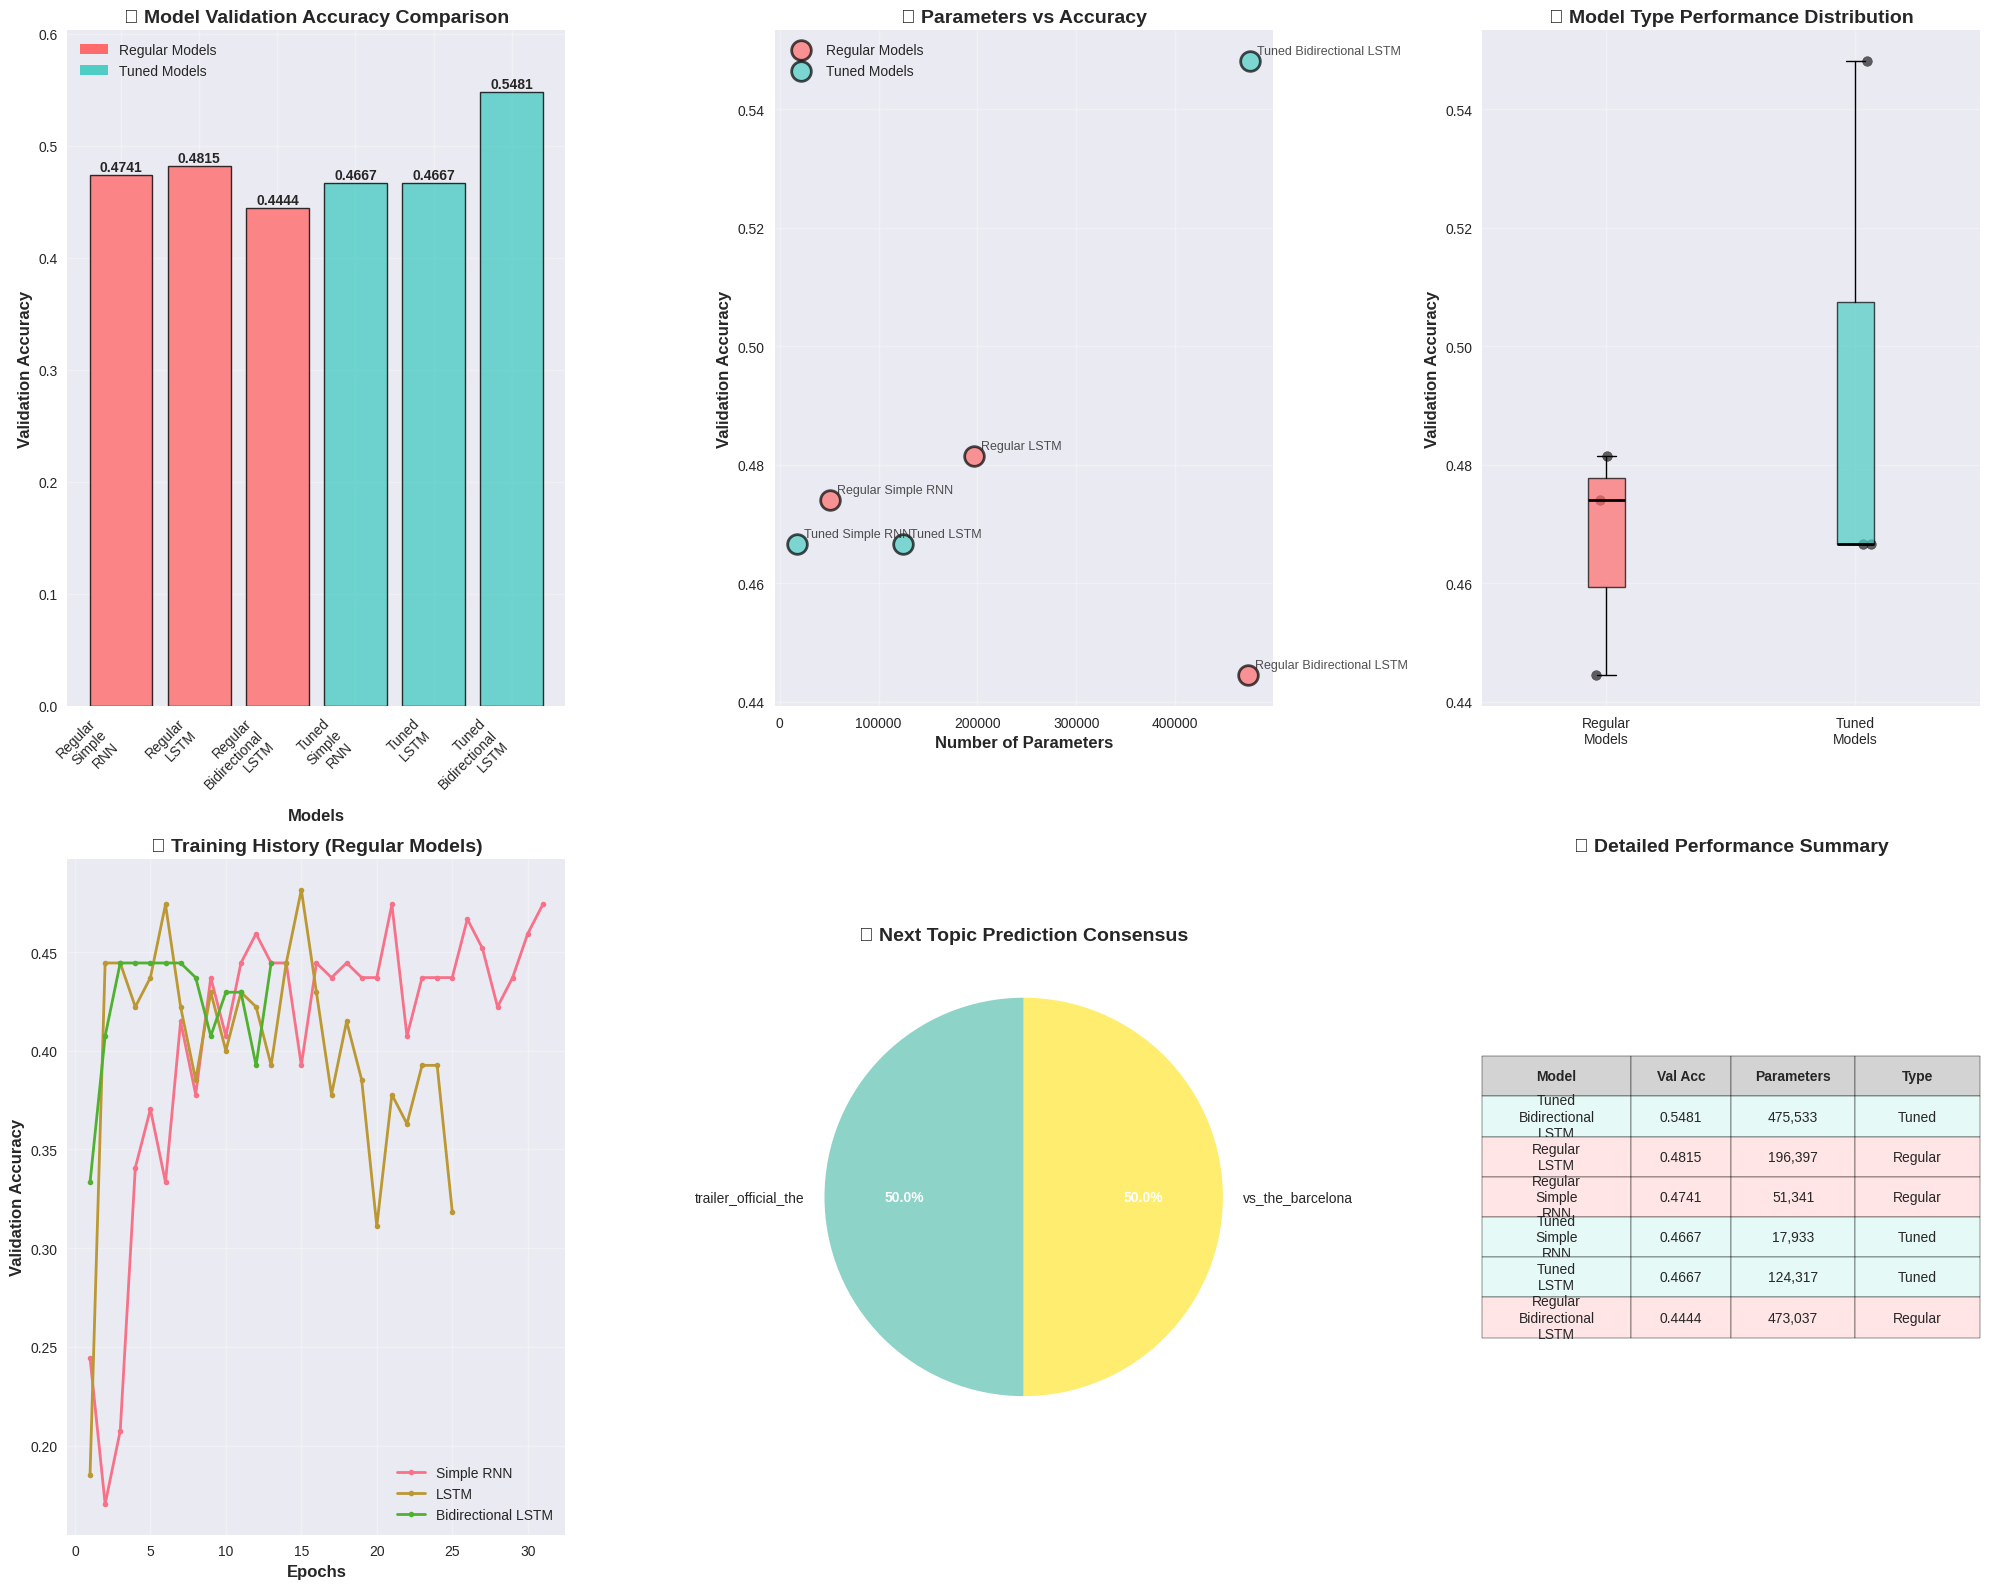

In [ ]:
print("📊 CREATING COMPREHENSIVE GRAPHICAL PERFORMANCE COMPARISON")
print("="*70)

# Extract data for plotting
model_names = []
val_accuracies = []
model_types = []
param_counts = []
predictions = []

for model_name, model_info in all_models.items():
    model_names.append(model_name.replace(' ', '\n'))  # Line breaks for better display
    val_accuracies.append(model_info['val_acc'])
    model_types.append(model_info['type'])
    param_counts.append(model_info['model'].count_params())

    # Get prediction for this model
    last_sequence = encoded_topics[-15:]
    input_seq = np.array([last_sequence])
    predicted_class = model_info['model'].predict(input_seq, verbose=0).argmax()
    predicted_topic = le.inverse_transform([predicted_class])[0]
    predictions.append(predicted_topic)

# Create a comprehensive figure with multiple subplots
fig = plt.figure(figsize=(20, 16))

# 1. Validation Accuracy Bar Chart
ax1 = plt.subplot(2, 3, 1)
colors = ['#FF6B6B' if t == 'regular' else '#4ECDC4' for t in model_types]
bars = ax1.bar(range(len(model_names)), val_accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=1)

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars, val_accuracies)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{acc:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax1.set_xlabel('Models', fontsize=12, fontweight='bold')
ax1.set_ylabel('Validation Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('🎯 Model Validation Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(range(len(model_names)))
ax1.set_xticklabels(model_names, rotation=45, ha='right', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, max(val_accuracies) * 1.1)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#FF6B6B', label='Regular Models'),
                   Patch(facecolor='#4ECDC4', label='Tuned Models')]
ax1.legend(handles=legend_elements, loc='upper left')

# 2. Model Parameters vs Accuracy Scatter Plot
ax2 = plt.subplot(2, 3, 2)
regular_mask = [t == 'regular' for t in model_types]
tuned_mask = [t == 'tuned' for t in model_types]

# Plot regular models
reg_params = [p for i, p in enumerate(param_counts) if regular_mask[i]]
reg_accs = [a for i, a in enumerate(val_accuracies) if regular_mask[i]]
reg_names = [n for i, n in enumerate(model_names) if regular_mask[i]]

# Plot tuned models
tuned_params = [p for i, p in enumerate(param_counts) if tuned_mask[i]]
tuned_accs = [a for i, a in enumerate(val_accuracies) if tuned_mask[i]]
tuned_names = [n for i, n in enumerate(model_names) if tuned_mask[i]]

scatter1 = ax2.scatter(reg_params, reg_accs, c='#FF6B6B', s=200, alpha=0.7,
                      edgecolors='black', linewidth=2, label='Regular Models')
scatter2 = ax2.scatter(tuned_params, tuned_accs, c='#4ECDC4', s=200, alpha=0.7,
                      edgecolors='black', linewidth=2, label='Tuned Models')

# Add labels for each point
for i, (x, y, name) in enumerate(zip(reg_params, reg_accs, reg_names)):
    ax2.annotate(name.replace('\n', ' '), (x, y), xytext=(5, 5), textcoords='offset points',
                fontsize=9, alpha=0.8)
for i, (x, y, name) in enumerate(zip(tuned_params, tuned_accs, tuned_names)):
    ax2.annotate(name.replace('\n', ' '), (x, y), xytext=(5, 5), textcoords='offset points',
                fontsize=9, alpha=0.8)

ax2.set_xlabel('Number of Parameters', fontsize=12, fontweight='bold')
ax2.set_ylabel('Validation Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('🔧 Parameters vs Accuracy', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Model Type Performance Comparison
ax3 = plt.subplot(2, 3, 3)
regular_accs = [a for i, a in enumerate(val_accuracies) if model_types[i] == 'regular']
tuned_accs = [a for i, a in enumerate(val_accuracies) if model_types[i] == 'tuned']

box_data = [regular_accs, tuned_accs]
box_labels = ['Regular\nModels', 'Tuned\nModels']
colors_box = ['#FF6B6B', '#4ECDC4']

bp = ax3.boxplot(box_data, labels=box_labels, patch_artist=True,
                 boxprops=dict(alpha=0.7), medianprops=dict(color='black', linewidth=2))

for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)

# Add individual points
for i, data in enumerate(box_data):
    y = data
    x = np.random.normal(i+1, 0.04, size=len(y))
    ax3.scatter(x, y, alpha=0.6, s=50, color='black')

ax3.set_ylabel('Validation Accuracy', fontsize=12, fontweight='bold')
ax3.set_title('📈 Model Type Performance Distribution', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. Training History Comparison (if available) - FIXED VERSION
ax4 = plt.subplot(2, 3, 4)
# Create a robust mapping for training history
history_plotted = False
# Define the correct mapping between all_models keys and results keys
results_key_mapping = {
    'Regular Simple RNN': 'Simple RNN',
    'Regular LSTM': 'Regular LSTM',
    'Regular Bidirectional LSTM': 'Bidirectional LSTM'
}
for model_name, model_info in all_models.items():
    if model_info['type'] == 'regular':
        # Try to find the correct key in results
        possible_keys = [
            results_key_mapping.get(model_name),  # Use mapping first
            model_name,  # Try exact match
            model_name.replace('Regular ', ''),  # Remove 'Regular ' prefix
            model_name.split()[-1],  # Try last word only
        ]
        # Filter out None values
        possible_keys = [key for key in possible_keys if key is not None]
        for key in possible_keys:
            if key in results and 'history' in results[key]:
                history = results[key]['history']
                if 'val_accuracy' in history.history and len(history.history['val_accuracy']) > 0:
                    epochs = range(1, len(history.history['val_accuracy']) + 1)
                    ax4.plot(epochs, history.history['val_accuracy'],
                            label=model_name.replace('Regular ', ''),
                            linewidth=2, marker='o', markersize=4)
                    history_plotted = True
                    break

# If no history was plotted, show a message
if not history_plotted:
    ax4.text(0.5, 0.5, 'No training history available\nfor regular models',
            ha='center', va='center', transform=ax4.transAxes,
            fontsize=12, style='italic')

ax4.set_xlabel('Epochs', fontsize=12, fontweight='bold')
ax4.set_ylabel('Validation Accuracy', fontsize=12, fontweight='bold')
ax4.set_title('📊 Training History (Regular Models)', fontsize=14, fontweight='bold')
if history_plotted:
    ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Prediction Consensus Pie Chart
ax5 = plt.subplot(2, 3, 5)
prediction_counts = Counter(predictions)
labels = list(prediction_counts.keys())
sizes = list(prediction_counts.values())
colors_pie = plt.cm.Set3(np.linspace(0, 1, len(labels)))

wedges, texts, autotexts = ax5.pie(sizes, labels=labels, autopct='%1.1f%%',
                                   colors=colors_pie, startangle=90)

# Beautify the pie chart
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

ax5.set_title('🎯 Next Topic Prediction Consensus', fontsize=14, fontweight='bold')

# 6. Detailed Performance Metrics
ax6 = plt.subplot(2, 3, 6)
# Create a performance summary table
metrics_data = []
for model_name, model_info in all_models.items():
    metrics_data.append([
        model_name.replace(' ', '\n'),
        f"{model_info['val_acc']:.4f}",
        f"{model_info['model'].count_params():,}",
        model_info['type'].title()
    ])

# Sort by validation accuracy
metrics_data.sort(key=lambda x: float(x[1]), reverse=True)

# Create table
table = ax6.table(cellText=metrics_data,
                  colLabels=['Model', 'Val Acc', 'Parameters', 'Type'],
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.3, 0.2, 0.25, 0.25])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Color code the rows
for i in range(1, len(metrics_data) + 1):
    if 'regular' in metrics_data[i-1][3].lower():
        color = '#FFE5E5'
    else:
        color = '#E5F9F6'

    for j in range(4):
        table[(i, j)].set_facecolor(color)

# Header styling
for j in range(4):
    table[(0, j)].set_facecolor('#D3D3D3')
    table[(0, j)].set_text_props(weight='bold')

ax6.axis('off')
ax6.set_title('📋 Detailed Performance Summary', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()



📊 INTERACTIVE MODEL COMPARISON
Debug: Regular scores: [0.4740740656852722, 0.48148149251937866, 0.4444444477558136]
Debug: Tuned scores: [0.46666666865348816, 0.46666666865348816, 0.5481481552124023]


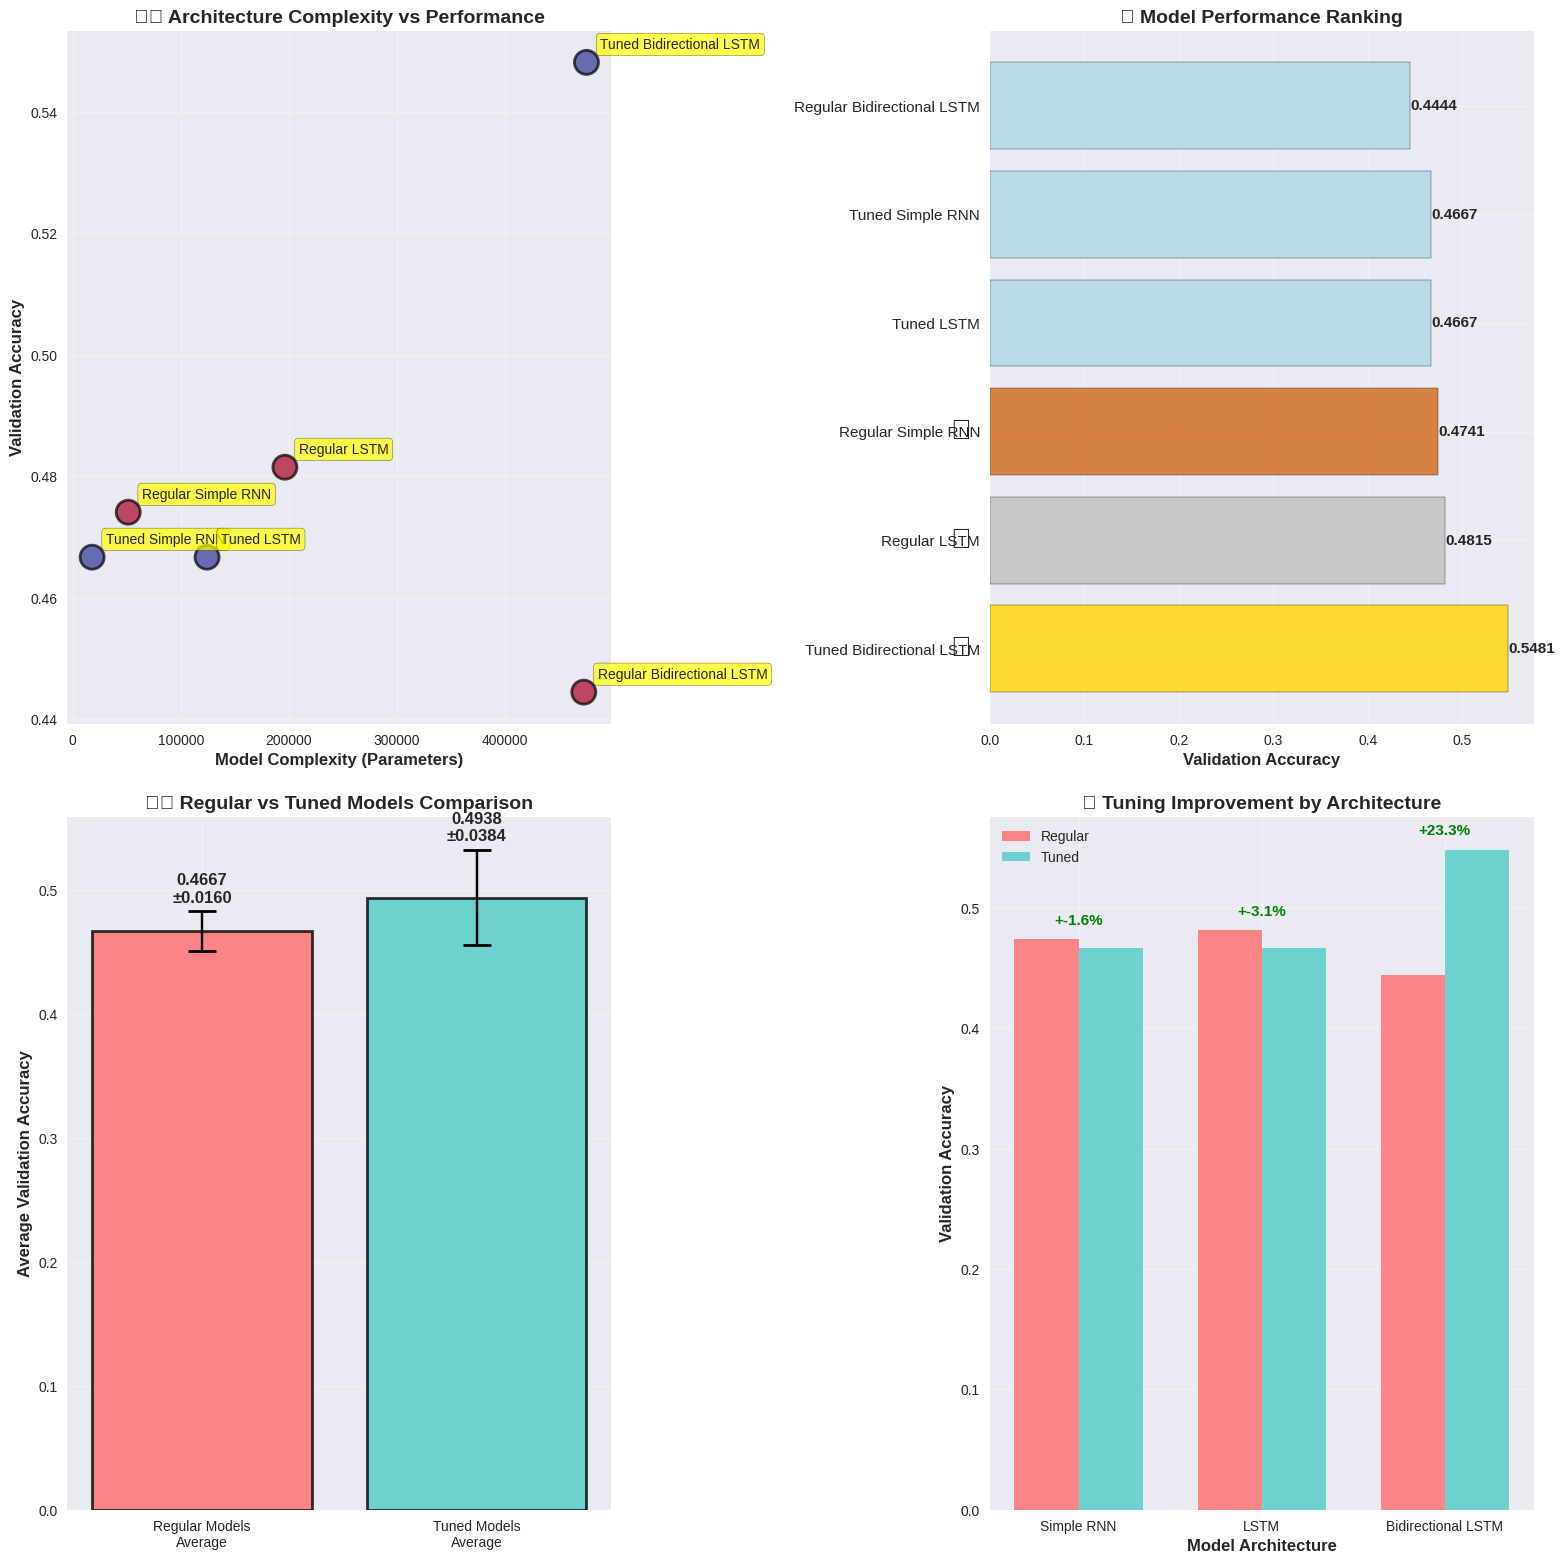

In [518]:
print("\n" + "="*70)
print("📊 INTERACTIVE MODEL COMPARISON")
print("="*70)

# Create a separate figure for model architecture comparison
fig2, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 16))

# 1. Architecture Complexity vs Performance
ax1.scatter(param_counts, val_accuracies, c=[0 if t == 'regular' else 1 for t in model_types],
           s=300, alpha=0.7, cmap='RdYlBu', edgecolors='black', linewidth=2)

for i, (x, y, name) in enumerate(zip(param_counts, val_accuracies, model_names)):
    ax1.annotate(name.replace('\n', ' '), (x, y), xytext=(10, 10),
                textcoords='offset points', fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

ax1.set_xlabel('Model Complexity (Parameters)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Validation Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('🏗️ Architecture Complexity vs Performance', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# 2. Performance Ranking
sorted_indices = np.argsort(val_accuracies)[::-1]
rankings = [model_names[i].replace('\n', ' ') for i in sorted_indices]
ranking_accs = [val_accuracies[i] for i in sorted_indices]
ranking_colors = ['gold' if i == 0 else 'silver' if i == 1 else 'chocolate' if i == 2 else 'lightblue'
                 for i in range(len(rankings))]

bars2 = ax2.barh(range(len(rankings)), ranking_accs, color=ranking_colors, alpha=0.8, edgecolor='black')

# Add accuracy values
for i, (bar, acc) in enumerate(zip(bars2, ranking_accs)):
    width = bar.get_width()
    ax2.text(width + 0.001, bar.get_y() + bar.get_height()/2.,
             f'{acc:.4f}', ha='left', va='center', fontsize=11, fontweight='bold')

ax2.set_yticks(range(len(rankings)))
ax2.set_yticklabels(rankings, fontsize=11)
ax2.set_xlabel('Validation Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('🏆 Model Performance Ranking', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add ranking medals
for i, (y, acc) in enumerate(zip(range(len(rankings)), ranking_accs)):
    if i == 0:
        ax2.text(-0.02, y, '🥇', ha='right', va='center', fontsize=20)
    elif i == 1:
        ax2.text(-0.02, y, '🥈', ha='right', va='center', fontsize=20)
    elif i == 2:
        ax2.text(-0.02, y, '🥉', ha='right', va='center', fontsize=20)

# 3. Regular vs Tuned Performance
ax3.bar(['Regular Models\nAverage', 'Tuned Models\nAverage'],
        [np.mean(regular_accs), np.mean(tuned_accs)],
        color=['#FF6B6B', '#4ECDC4'], alpha=0.8, edgecolor='black', linewidth=2)

# Add error bars (standard deviation)
ax3.errorbar(['Regular Models\nAverage', 'Tuned Models\nAverage'],
            [np.mean(regular_accs), np.mean(tuned_accs)],
            yerr=[np.std(regular_accs), np.std(tuned_accs)],
            fmt='none', color='black', capsize=10, capthick=2)

# Add value labels
for i, (avg, std) in enumerate(zip([np.mean(regular_accs), np.mean(tuned_accs)],
                                  [np.std(regular_accs), np.std(tuned_accs)])):
    ax3.text(i, avg + std + 0.005, f'{avg:.4f}\n±{std:.4f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax3.set_ylabel('Average Validation Accuracy', fontsize=12, fontweight='bold')
ax3.set_title('⚖️ Regular vs Tuned Models Comparison', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. Improvement Analysis - FIXED VERSION
model_bases = ['Simple RNN', 'LSTM', 'Bidirectional LSTM']
regular_scores = []
tuned_scores = []

# Create a more robust mapping
model_mapping = {
    'Simple RNN': 'Tuned Simple RNN',
    'LSTM': 'Tuned LSTM',
    'Bidirectional LSTM': 'Tuned Bidirectional LSTM'
}

for base in model_bases:
    regular_key = f'Regular {base}'
    tuned_key = model_mapping[base]

    # Find regular model score
    if regular_key in all_models:
        regular_scores.append(all_models[regular_key]['val_acc'])
    else:
        print(f"Warning: {regular_key} not found")
        regular_scores.append(0)  # Default value

    # Find tuned model score
    if tuned_key in all_models:
        tuned_scores.append(all_models[tuned_key]['val_acc'])
    else:
        print(f"Warning: {tuned_key} not found")
        tuned_scores.append(0)  # Default value

# Ensure both arrays have the same length
if len(regular_scores) != len(tuned_scores):
    print(f"Warning: Length mismatch - regular: {len(regular_scores)}, tuned: {len(tuned_scores)}")
    # Pad the shorter array with zeros
    max_len = max(len(regular_scores), len(tuned_scores))
    regular_scores.extend([0] * (max_len - len(regular_scores)))
    tuned_scores.extend([0] * (max_len - len(tuned_scores)))

print(f"Debug: Regular scores: {regular_scores}")
print(f"Debug: Tuned scores: {tuned_scores}")

x = np.arange(len(model_bases))
width = 0.35

bars1 = ax4.bar(x - width/2, regular_scores, width, label='Regular', color='#FF6B6B', alpha=0.8)
bars2 = ax4.bar(x + width/2, tuned_scores, width, label='Tuned', color='#4ECDC4', alpha=0.8)

# Add improvement percentages - with safety check
for i, (reg, tuned) in enumerate(zip(regular_scores, tuned_scores)):
    if reg > 0:  # Avoid division by zero
        improvement = ((tuned - reg) / reg) * 100
        ax4.text(i, max(reg, tuned) + 0.01, f'+{improvement:.1f}%',
                ha='center', va='bottom', fontsize=11, fontweight='bold', color='green')

ax4.set_xlabel('Model Architecture', fontsize=12, fontweight='bold')
ax4.set_ylabel('Validation Accuracy', fontsize=12, fontweight='bold')
ax4.set_title('📈 Tuning Improvement by Architecture', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(model_bases)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout(pad=2.0)
plt.show()

In [515]:
# Performance Statistics Summary
print(f"\n🎯 PERFORMANCE STATISTICS SUMMARY:")
print("-" * 50)
print(f"🏆 Best Model: {sorted_models[0][0]} ({sorted_models[0][1]['val_acc']:.4f})")
print(f"📊 Average Accuracy: {np.mean(val_accuracies):.4f}")
print(f"📈 Accuracy Range: {min(val_accuracies):.4f} - {max(val_accuracies):.4f}")
print(f"🔧 Average Improvement from Tuning: {np.mean([(tuned_scores[i] - regular_scores[i])/regular_scores[i]*100 for i in range(len(regular_scores))]):.1f}%")
print(f"💪 Most Improved Architecture: {model_bases[np.argmax([(tuned_scores[i] - regular_scores[i])/regular_scores[i]*100 for i in range(len(regular_scores))])]}")


🎯 PERFORMANCE STATISTICS SUMMARY:
--------------------------------------------------
🏆 Best Model: Tuned Bidirectional LSTM (0.5481)
📊 Average Accuracy: 0.4802
📈 Accuracy Range: 0.4444 - 0.5481
🔧 Average Improvement from Tuning: 6.2%
💪 Most Improved Architecture: Bidirectional LSTM


### Next 10 topics

In [505]:
def predict_next_n_topics(model, le, encoded_topics, n_predictions=10, sequence_length=15):
    # ? start with the last sequence from training data
    current_sequence = list(encoded_topics[-sequence_length:])
    predicted_topics = []

    for i in range(n_predictions):
        # ? reshape for model input
        input_seq = np.array([current_sequence])

        # ? predict
        predicted_probs = model.predict(input_seq, verbose=0)
        predicted_class = predicted_probs.argmax()

        # ? store prediction
        predicted_topics.append(predicted_class)

        # ? update sequence: remove first element, add prediction
        current_sequence = current_sequence[1:] + [predicted_class]

    # ? convert encoded predictions back to topic names
    predicted_topic_names = le.inverse_transform(predicted_topics)
    return predicted_topic_names, predicted_topics

In [506]:
print("\n" + "="*100)
print("NEXT 10 TOPIC PREDICTIONS - ALL MODELS")
print("="*100)

# Generate predictions for all models
all_model_predictions = {}

for model_name, model_info in all_models.items():
    model = model_info['model']
    predicted_names, predicted_encoded = predict_next_n_topics(
        model, le, encoded_topics, n_predictions=10, sequence_length=15
    )
    all_model_predictions[model_name] = {
        'names': predicted_names,
        'encoded': predicted_encoded,
        'val_acc': model_info['val_acc']
    }

# Display predictions for each model
for model_name, predictions in all_model_predictions.items():
    model_type = all_models[model_name]['type']
    val_acc = predictions['val_acc']

    print(f"\n{'-'*60}")
    print(f"🤖 {model_name.upper()} ({model_type.title()}) - Val Acc: {val_acc:.4f}")
    print(f"{'-'*60}")

    for i, (name, encoded) in enumerate(zip(predictions['names'], predictions['encoded']), 1):
        print(f"{i:2d}. {name} (encoded: {encoded})")

    print(f"\n📝 Sequence: {' → '.join(predictions['names'])}")

# Comprehensive comparison table
print(f"\n" + "="*120)
print("📊 SIDE-BY-SIDE COMPARISON TABLE")
print("="*120)

# Create headers
model_names = list(all_model_predictions.keys())
header = f"{'Pos':<4}"
for name in model_names:
    header += f"{name:<20}"
print(header)
print("-" * 120)

# Create comparison rows
for i in range(10):
    row = f"{i+1:<4}"
    for model_name in model_names:
        prediction = all_model_predictions[model_name]['names'][i]
        # Truncate long topic names for display
        display_pred = prediction[:17] + "..." if len(prediction) > 20 else prediction
        row += f"{display_pred:<20}"
    print(row)

# Accuracy ranking
print(f"\n🏅 MODEL RANKING BY VALIDATION ACCURACY:")
print("-" * 50)
sorted_by_acc = sorted(all_model_predictions.items(), key=lambda x: x[1]['val_acc'], reverse=True)

for rank, (model_name, pred_info) in enumerate(sorted_by_acc, 1):
    model_type = all_models[model_name]['type']
    emoji = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else "🏅"
    print(f"{emoji} {rank}. {model_name} ({model_type}): {pred_info['val_acc']:.4f}")

# Consensus analysis
print(f"\n🔍 PREDICTION CONSENSUS ANALYSIS:")
print("-" * 40)

# Count how often each topic appears in position 1
first_predictions = [pred_info['names'][0] for pred_info in all_model_predictions.values()]
from collections import Counter
consensus_count = Counter(first_predictions)

print("Next topic consensus:")
for topic, count in consensus_count.most_common():
    percentage = (count / len(all_model_predictions)) * 100
    print(f"  {topic}: {count}/{len(all_model_predictions)} models ({percentage:.1f}%)")

# Summary statistics
print(f"\n📋 SUMMARY:")
print(f"   Total Models Compared: {len(all_models)}")
print(f"   Regular Models: {len([m for m in all_models.values() if m['type'] == 'regular'])}")
print(f"   Tuned Models: {len([m for m in all_models.values() if m['type'] == 'tuned'])}")
print(f"   Best Validation Accuracy: {max(info['val_acc'] for info in all_models.values()):.4f}")
print(f"   Average Validation Accuracy: {sum(info['val_acc'] for info in all_models.values()) / len(all_models):.4f}")


NEXT 10 TOPIC PREDICTIONS - ALL MODELS

------------------------------------------------------------
🤖 REGULAR SIMPLE RNN (Regular) - Val Acc: 0.4741
------------------------------------------------------------
 1. trailer_official_the (encoded: 11)
 2. trailer_official_the (encoded: 11)
 3. vs_the_barcelona (encoded: 12)
 4. vs_the_barcelona (encoded: 12)
 5. vs_the_barcelona (encoded: 12)
 6. vs_the_barcelona (encoded: 12)
 7. vs_the_barcelona (encoded: 12)
 8. vs_the_barcelona (encoded: 12)
 9. vs_the_barcelona (encoded: 12)
10. vs_the_barcelona (encoded: 12)

📝 Sequence: trailer_official_the → trailer_official_the → vs_the_barcelona → vs_the_barcelona → vs_the_barcelona → vs_the_barcelona → vs_the_barcelona → vs_the_barcelona → vs_the_barcelona → vs_the_barcelona

------------------------------------------------------------
🤖 REGULAR LSTM (Regular) - Val Acc: 0.4815
------------------------------------------------------------
 1. trailer_official_the (encoded: 11)
 2. trailer_offi